<a href="https://colab.research.google.com/github/kittisaktaoma/colab_practice/blob/master/CalcSynergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library 



In [ ]:
! wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
! chmod +x Miniconda3-latest-Linux-x86_64.sh
! ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
! conda config --set always_yes yes --set changeps1 no
! conda install -q -y -c conda-forge python=3.7
! conda install -q -y -c conda-forge rdkit==2020.09.2 

In [214]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem

In [ ]:
! pip install keras
! pip install tensorflow
! pip install keras-gcn
! pip install numpy
! pip install matplotlib
! pip install scipy
! pip install deepchem
! pip install keras-tuner
! pip install pubchempy
! pip install chembl_webresource_client

In [216]:
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
import deepchem as dc
from rdkit import Chem
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import BayesianOptimization
from chembl_webresource_client.new_client import new_client
import tensorflow as tf
from tensorflow.keras.backend import variable, dot as k_dot, sigmoid, relu
from tensorflow.keras.layers import Dense, Input, Concatenate, Layer
import numpy as np
import urllib
import pubchempy as pcp

In [217]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

#Toy data

In [218]:
sample_01 = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,1]
sample_02 = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,2]
all_sample = sample_01.append(sample_02).unique()
all_sample[:5].__len__()

5

#Drug structure


In [219]:
drug_smiles = {}
cnt = 1
for i in all_sample[:5]:
  try:
    res = pcp.get_compounds(i, 'name')
    SM = res[0].canonical_smiles   
    drug_smiles[i] = SM
    if  cnt == len(all_sample[:5]):
       curated_df = pd.DataFrame(drug_smiles.items(), columns=['Name', 'smiles'])
    cnt = cnt + 1
  except Exception:
    pass

In [275]:
curated_df

,Name,smiles
0,5-FU,C1=C(C(=O)NC(=O)N1)F
1,ABT-888,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N.Cl.Cl
2,AZD1775,CC(C)(C1=NC(=CC=C1)N2C3=NC(=NC=C3C(=O)N2CC=C)N...
3,BEZ-235,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...
4,BORTEZOMIB,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...


In [ ]:
feat_mat = {}

#curated_df.shape[0]
for i in range(curated_df.shape[0]):
  """
  create normalize adjacency matrix
  """
  mol = Chem.MolFromSmiles(curated_df.iloc[i,1])
  A = Chem.GetAdjacencyMatrix(mol).tolist()
  I = np.eye(A.__len__())

  A_hat = np.array(A + I)




  """
  create feaature matrix
  """

  f1 = [[mol.GetAtomWithIdx(j).GetIsAromatic() for j in range(mol.GetNumAtoms())]]
  c = pd.DataFrame(f1).T
  f2 = [[mol.GetAtomWithIdx(j).GetNumRadicalElectrons() for j in range(mol.GetNumAtoms())]]
  l = pd.DataFrame(f2).T
  h = pd.concat([c,l],axis=1)
  h_01 = h.replace([True],1)
  h_02 = h_01.replace([False],0)
  f = np.array(h_02)

  """
  Multiply
  """
  feat_mat[curated_df.iloc[i,0]] = A_hat @ f

print(feat_mat)

In [459]:
df = [feat_mat[curated_df.iloc[i,0]] for i in range(curated_df.shape[0])]
df[0:2]

[array([[3., 0.],
        [3., 0.],
        [3., 0.],
        [1., 0.],
        [3., 0.],
        [3., 0.],
        [1., 0.],
        [3., 0.],
        [1., 0.]]), array([[0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [3., 0.],
        [3., 0.],
        [4., 0.],
        [3., 0.],
        [3., 0.],
        [3., 0.],
        [3., 0.],
        [4., 0.],
        [3., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])]

In [ ]:
from keras.preprocessing.sequence import pad_sequences
max_atom_number = max([df[i].__len__() for i in range(len(df))])
paddedpad_sequences(df, padding='post',maxlen=max_atom_number)

#Model

In [432]:
class GraphConv(Layer):
    
    """
    GraphConv require two inputs: padding feature and padding adjacency matrix of each drug

    """
    def __init__(self,output_dim,activation="sigmoid"):
        super().__init__()
        self.units = output_dim
        self.activation_function = activation

    def build(self, input_shape):
        
        """ 
        weight in GCN : 
        row is number of feature
        column is the number of output node

        """
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units), 
            initializer="random_normal",
            trainable=True)
        
    

    def call(self,inputs):
      """
      Inputs = padding feature matrix 
      A = padding adjacency matrix

      """
      if self.activation_function == 'relu':
        return relu(inputs @ self.w)
      else:
        return sigmoid(inputs @ self.w)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 9, 2)]            0         
_________________________________________________________________
graph_conv_7 (GraphConv)     (None, 9, 2)              4         
_________________________________________________________________
graph_conv_8 (GraphConv)     (None, 9, 2)              4         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 2)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 6   

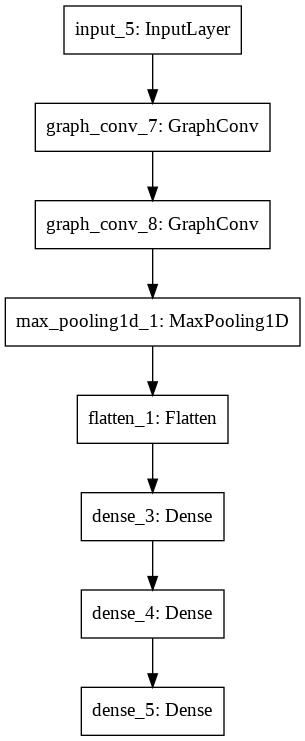

In [436]:
# first input model
visible1 = Input(shape=(9,2))
layer1 = GraphConv(2,activation='relu')(visible1)
layer2 = GraphConv(2,activation='relu')(layer1)
pool12 = tf.keras.layers.MaxPooling1D()(layer2)
flat1 = Flatten()(pool12)
# second input model
#visible2 = Input(shape=(32,32,3))
#conv21 = Conv2D(32, kernel_size=4, activation='relu')(visible2)
#pool21 = MaxPooling2D(pool_size=(2, 2))(conv21)
#conv22 = Conv2D(16, kernel_size=4, activation='relu')(pool21)
#pool22 = MaxPooling2D(pool_size=(2, 2))(conv22)
#flat2 = Flatten()(pool22)
# merge input models
#merge = concatenate([flat1, flat2])
# interpretation model
hidden1 = Dense(2, activation='relu')(flat1)
hidden2 = Dense(2, activation='relu')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)
model = Model(inputs=visible1, outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='multilayer_perceptron_graph.png')

##Simulate data

In [ ]:
def tune_nn_model(hp):
    model = keras.Sequential()
    
    drop_rate = hp.Choice('drop_rate',
                            [
                              0.0,
                              0.1,
                              0.2,
                              0.3,
                              0.4,
                              0.5,
                              0.6,
                              0.7,
                              0.8,
                              0.9
                            ])

     
    model.add(keras.layers.Dense(
      units=28,
      activation="relu",
      input_shape=[df_x.shape[1]]
    ))
    model.add(keras.layers.Dropout(rate=drop_rate))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dropout(rate=drop_rate))
    model.add(keras.layers.Dense(1, activation='sigmoid')) 
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    momentum = hp.Choice('momentum', [0.0, 0.2, 0.4, 0.6, 0.8, 0.9])

    model.compile(
        optimizer=keras.optimizers.SGD(lr, momentum=momentum),
        loss = 'binary_crossentropy',
        metrics = ['accuracy'])
    return model

In [ ]:
b_tuner = BayesianOptimization(
    tune_nn_model,
    objective='accuracy',
    max_trials=20,
    executions_per_trial=5,
    directory='test_dir_03',
    project_name='b_tune_nn'
)

INFO:tensorflow:Reloading Oracle from existing project test_dir_03/b_tune_nn/oracle.json


In [ ]:
df_x_x = df_x.to_numpy()
df_y_y = df_y.to_numpy()

In [ ]:
b_tuner.search(df_x_x,df_y_y)

In [ ]:
b_tuner.results_summary()

In [ ]:
# Retrieve the best model and display its architecture
best_model = b_tuner.get_best_models(num_models=1)[0]
best_model.summary()

### Remaining Drug

In [ ]:
#filterremaining drug from dataset
remaining_drug = res_target_protein_stitch['Drug_name'].unique().tolist()
remain_df_01 = df[df["drug_row"].isin(remaining_drug)]
remain_df_02 = remain_df_01[remain_df_01["drug_col"].isin(remaining_drug)]
remain_df_03 = remain_df_02[['cell_line_name','drug_row','drug_col','synergy_loewe']]
remain_df_04 = remain_df_03.groupby(['cell_line_name','drug_row','drug_col']).agg({'synergy_loewe': 'mean'}).reset_index()
remain_df_04


,cell_line_name,drug_row,drug_col,synergy_loewe
0,BT-549,5-FLUORO-2'-DEOXYURIDINE,ALLOPURINOL,-0.4400
1,BT-549,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,0.2300
2,BT-549,5-FLUORO-2'-DEOXYURIDINE,ANASTROZOLE,-2.5300
3,BT-549,5-FLUORO-2'-DEOXYURIDINE,AZACYTIDINE,2.1500
4,BT-549,5-FLUORO-2'-DEOXYURIDINE,BLEOMYCIN,-0.2000
...,...,...,...,...
16345,ZR751,ZOLINZA,SN-38,0.3000
16346,ZR751,ZOLINZA,SORAFENIB,1.8425
16347,ZR751,ZOLINZA,SUNITINIB,-9.8175
16348,ZR751,ZOLINZA,TEMOZOLOMIDE,-67.0150


#Concatete data

##target protein

In [ ]:
pd.read_csv("http://stitch.embl.de/api/tsv/interactors?identifier=1423&species=9606:smiles",sep="\t")

In [ ]:
x_tmp = tartget_protein_df.unstack()
df_tmp = pd.DataFrame(x_tmp.0.str.split(' ',1).tolist(),
                                 columns = ['flips','row'])


0
itemId          Drug_name                  
ENSP00000001146 5-FLUORO-2'-DEOXYURIDINE  0
                5-FU                      0
                ABIRATERONE               0
                ABT-888                   0
                ALLOPURINOL               0
...                                      ..
ENSP00000464149 VEMURAFENIB               0
                VINBLASTINE               0
                VINORELBINE               0
                VISMODEGIB                0
                ZOLINZA                   0

[38804 rows x 1 columns]

In [ ]:
pd.merge(remain_df_04, climate_precip, on=["STATION", "DATE"])

,cell_line_name,drug_row,drug_col,synergy_loewe
0,BT-549,5-FLUORO-2'-DEOXYURIDINE,ALLOPURINOL,-0.4400
1,BT-549,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,0.2300
2,BT-549,5-FLUORO-2'-DEOXYURIDINE,ANASTROZOLE,-2.5300
3,BT-549,5-FLUORO-2'-DEOXYURIDINE,AZACYTIDINE,2.1500
4,BT-549,5-FLUORO-2'-DEOXYURIDINE,BLEOMYCIN,-0.2000
...,...,...,...,...
16345,ZR751,ZOLINZA,SN-38,0.3000
16346,ZR751,ZOLINZA,SORAFENIB,1.8425
16347,ZR751,ZOLINZA,SUNITINIB,-9.8175
16348,ZR751,ZOLINZA,TEMOZOLOMIDE,-67.0150
